In [47]:
from pathlib import Path
from pybeerxml import Parser
import sys
import numpy as np
import re
import csv
import json
import random
import concurrent.futures
from matplotlib import pyplot as plt
 
sys.path.append('../')
from brewgen.backend.models import grain, category, hop

In [34]:
def points(og):
    return (og - 1) * 1000


with open('styleguide-2015.json', 'r') as f:
    bjcp = json.load(f)


def bjcp_name(name):
    """Return beer stats for a style name"""
    for bev_class in bjcp['styleguide']['class']:
        if bev_class['type'] == 'beer':
            for style_category in bev_class['category']:
                for subcat in style_category['subcategory']:
                    if subcat['name'] == name:
                        return subcat.get('stats', {})

In [35]:
all_grains = grain.GrainModel()
all_hops = hop.HopModel()
category_model = category.CategoryModel()

fermentable_keywords = all_grains.get_sensory_keywords()
hop_keywords = all_hops.get_sensory_keywords()
fermentable_categories = category_model.get_category_names()

styles = []
for bev_class in bjcp['styleguide']['class']:
    if bev_class['type'] == 'beer':
        for style_category in bev_class['category']:
            for subcat in style_category['subcategory']:
                styles.append(subcat['name'])

parser = Parser()


# Define fermentable, style, and hop rewrite rules
fermentable_rewrites = [
    {
        'name': 'Goldpils Vienna Malt',
        'match': "^.*(Goldpils|Vienna.*US|US.*Vienna|Briess.*Vienna|Vienna.*Briess).*$",
        'max_color': 6
    },
    # as the catchall for Vienna
    {
        'name': 'Vienna Malt',
        'match': '^.*Vienna.*$',
        'max_color': 6
    }, {
        'name': 'Munich Malt I',
        "match": '^.*Munich.*$',
        'max_color': 7
    },
    {
        'name': 'Munich Malt II',
        "match": '^.*Munich.*$',
        'max_color': 9.9
    },
    {
        'name': 'Munich Malt 10L',
        "match": '^.*Munich.*$',
        'max_color': 11
    },
    {
        'name': 'Munich Malt 20L',
        "match": '^.*Munich.*$',
        'max_color': 21
    },
    {
        'name': "Brewer's Malt",
        'match': '^.*((2|Two)(-| )Row|Pale Malt|Ale Malt).*$',
        'max_color': 3.5
    },
    # No sensory available for Maris Otter so lumping that in with Pale Ale Malt
    {
        'name': "Pale Ale Malt",
        'match': '^.*(Pale Ale|Maris|Marris|Ale Malt).*$',
        'max_color': 5
    },
    {
        'name': "Carapils Malt",
        'match': '^.*(Carafoam|US.*Carapils|Carapils.*US|Carapils.*Briess|Briess.*Carapils|Cara-Pils|Dextrine).*$',
        'max_color': 5
    },
    # as the catchall for Carapils
    {
        'name': "Carapils",
        'match': '^.*(Carapils).*$',
        'max_color': 5
    },
    {
        'name': "CaraHell",
        'match': '^.*(Cara Malt|Hell).*$',
        'min_color': 5,
        'max_color': 15
    },
    {
        'name': "CaraHell",
        'match': '^.*Caramel Pils.*$',
        'min_color': 5,
        'max_color': 15
    },
    {
        'name': "Carapils Malt",
        'match': '^.*Caramel Pils.*$',
        'max_color': 5
    },
    {
        'name': "Pilsen Malt",
        'match': '^.*(Pilsen|US.*Pilsner|Pilsner.*US|Lager).*$',
        'max_color': 3
    },
    # as the catchall for Pilsner
    {
        'name': "Pilsner Malt",
        'match': '^.*Pilsner.*$',
        'max_color': 3.5
    },
    {
        'name': "Pale Chocolate Malt",
        'match': '^.*Chocolate.*$',
        'max_color': 240
    },
    {
        'name': "Chocolate Malt",
        'match': '^.*Chocolate.*$',
        'max_color': 360
    },
    # Dark chocolate as the chocolate catchall
    {
        'name': "Dark Chocolate Malt",
        'match': '^.*Chocolate.*$',
    },
    {
        'name': "Special B",
        'match': '^.*Special (W|B).*$'
    },
    {
        'name': "Amber Malt",
        'match': '^(Amber|Amber.*UK.*|(Crisp|British) Amber|.*Amber Malt.*)$'
    },
    {
        'name': "CaraMunich I",
        'match': '^.*Cara ?munich(( I)?|.*Type 1).*$',
        'max_color': 40
    },
    {
        'name': "CaraMunich II",
        'match': '^.*Cara ?munich(( II)?|.*Type 2).*$',
        'max_color': 50
    },
    {
        'name': "CaraMunich III",
        'match': '^.*Cara ?munich(( III)?|.*Type 3).*$',
        'max_color': 60
    },
    {
        'name': "Caramel Malt 10L",
        'match': '^.*(Crystal|Caramel).*15.*$',
        'max_color': 15.1
    },
    {
        'name': "Caramel Malt 20L",
        'match': '^.*(Crystal|Caramel).*15.*$',
        'min_color': 15.1,
        'max_color': 20
    },
    {
        'name': "Pale Wheat Malt",
        'match': '^.*((Belgian|German).*Wheat|Wheat.*(DE|BE|Belgian|German)).*$'
    },
    {
        'name': "Wheat Malt, White",
        'match': '^.*(White Wheat|Pale Wheat|Wheat Malt|Light Wheat|Wheat.*US).*$'
    },
    {
        'name': "Brewers Red Wheat Flakes",
        'match': '^.*(Flak.*Wheat|Wheat.*Flak).*$'
    },
    # Red wheat as the wheat catchall
    {
        'name': "Wheat Malt, Red",
        'match': '^.*Wheat.*$',
        'max_color': 4
    },
    {
        'name': "Lactose (Milk Sugar)",
        'match': '^.*(Lactose|Milk Sugar).*$'
    },
    {
        'name': "Brewers Torrified Wheat",
        'match': '^.*(Wheat.*Torrified|Torrified Wheat).*$'
    },
    {
        'name': "Dextrose (Corn Sugar)",
        'match': '^.*(Corn Sugar|Dextrose).*$'
    },
    {
        'name': "Brewers Barley Flakes",
        'match': '^.*(Barley.*Flaked|Flaked.*Barley).*$'
    },
    {
        'name': "Brewers Rye Flakes",
        'match': '^.*(Rye.*Flaked|Flaked.*Rye).*$'
    },
    {
        'name': 'Flaked Rice',
        'match': '^Rice, Flaked$'
    },
    {
        'name': 'Caramel Vienne Malt 20L',
        'match': '^.*(CaraVienn(a|e)|Cara Vienna).*$'
    },
    {
        'name': "Munich Malt 20L",
        'match': '^.*Aromatic.*$',
        'min_color': 15,
        'max_color': 25
    },
    {
        'name': "Melanoidin Malt",
        'match': '^.*Aromatic.*$',
        'min_color': 25,
        'max_color': 65
    },
    {
        'name': 'Smoked Malt, Mesquite',
        'match': '^.*Smoked Malt.*$',
        'min_color': 4,
        'max_color': 6
    },
    {
        'name': 'Beech Smoked Barley Malt',
        'match': '^.*Smoked Malt.*$',
        'min_color': 1,
        'max_color': 4
    },
    {
        'name': "Brewers Oat Flakes",
        'match': '^.*(Oat.*(Flake|Roll)|(Flake|Roll).*Oat).*$'
    },
    {
        'name': "Brewers Yellow Corn Flakes",
        'match': '^.*((Corn|Maize).*Flaked|Flaked.*(Corn|Maize)).*$'
    },
    {
        'name': "Black Malt",
        'match': '^.*((?!de-?bittered)).*(Black Malt|Black Patent).*$',
        'min_color': 400,
        'max_color': 650
    },
    {
        'name': "Honey Malt",
        'match': '^.*(Honey.*Malt|Malt.*Honey|Honey.*US|Honey.*CA|Honey.*Gambrinus|Gambrinus.*Honey).*$',
        'min_color': 15
    },
    {
        'name': 'Victory Malt',
        'match': '^.*(Victory|Biscuit).*$'
    },
    {
        'name': 'Brown Malt',
        'match': '^.*Brown Malt.*$|^Brown$'
    },
    {
        'name': 'Rye Malt',
        'match': '^.*(US.*Rye|Rye.*US).*$|^Rye$'
    },
    {
        'name': "6-Row Brewers Malt",
        'match': '^.*6.Row.*$',
        'max_color': 4
    },
    {
        'name': "Golden Promise",
        'match': '^.*Golden.*Promise.*$'
    },
    {
        'name': "Roasted Barley",
        'match': '^.*Roast.*Barley.*$'
    },
    {
        'name': "Pale Wheat Malt",
        'match': '^.*Pale Wheat Malt.*$'
    },
    {
        'name': "Acid Malt",
        'match': '^.*Acid.*Malt.*$'
    },
    {
        'name': "Sucrose (Table Sugar)",
        'match': '^.*(Sucrose|Table.*Sugar|Cane.*Sugar).*$'
    },
    {
        'name': "Melanoidin Malt",
        'match': '^.*Mel.noid.*$'
    },
    {
        'name': "Brown Sugar, Light",
        'match': '^.*Brown Sugar.*$',
        'max_color': 20
    },
    {
        'name': "Brown Sugar, Dark",
        'match': '^.*Brown Sugar.*$',
        'max_color': 60
    },
    {
        'name': "Carafa Special I",
        'match': '^.*Carafa.*$',
        'max_color': 375
    },
    {
        'name': "Carafa Special II",
        'match': '^.*Carafa.*$',
        'max_color': 475
    },
    {
        'name': "Carafa Special III",
        'match': '^.*Carafa.*$',
        'max_color': 575
    }
]
style_rewrites = [
    {
        'new': 'California Common',
        'old': '^.*California Common Beer.*$'
    },
    {
        'new': 'Historical Beer: Gose',
        'old': '^.*Gose.*$'
    },
    {
        'new': 'International Dark Lager',
        'old': '^.*Dark American Lager.*$'
    },
    {
        'new': 'Specialty Smoked Beer',
        'old': '^Other Smoked Beer$'
    },
    {
        'new': 'Historical Beer: Pre-Prohibition Lager',
        'old': '^.*(Classic American Pilsner|Pre-Prohibition Lager).*$'
    },
    {
        'new': 'Historical Beer: Kentucky Common',
        'old': '^.*Kentucky Common.*$'
    },
    {
        'new': 'Winter Seasonal Beer',
        'old': '^.*Holiday/Winter Special Spiced Beer.*$'
    },
    {
        'new': 'Ordinary Bitter',
        'old': '^.*Standard/Ordinary Bitter.*$'
    },
    {
        'new': 'British Brown Ale',
        'old': '^.*English Brown.*$'
    },
    {
        'new': 'International Lager',
        'old': '^.*Premium American Lager.*$'
    },
    {
        'new': 'Strong Bitter',
        'old': '^.*Strong Bitter.*$'
    },
    {
        'new': 'Imperial Stout',
        'old': '^.*Imperial Stout.*$'
    },
    {
        'new': 'American Wheat Beer',
        'old': '^.*American (Wheat|Rye).*$'
    },
    {
        'new': 'American Porter',
        'old': '^.*Robust Porter.*$'
    },
    {
        'new': 'Irish Stout',
        'old': '^.*Dry.*Stout.*$'
    },
    {
        'new': 'Experimental Beer',
        'old': '^.*Specialty Beer.*$'
    },
    {
        'new': 'Best Bitter',
        'old': '^.*Best.*Bitter.*$'
    },
    {
        'new': 'Weissbier',
        'old': '^.*(Weizen|Weissbier).*$'
    },
    {
        'new': 'Double IPA',
        'old': '^.*Imperial IPA.*$'
    },
    {
        'new': 'German Pils',
        'old': '^.*German.*Pils.*$'
    },
    {
        'new': 'Märzen',
        'old': '^.*(Oktoberfest|M.rzen).*$'
    },
    {
        'new': 'Altbier',
        'old': '^.*(D.sseldorf|Altbier).*$'
    },
    {
        'new': 'Scottish Export',
        'old': '^.*Scottish.*Export.*$'
    },    {
        'new': 'Kölsch',
        'old': '^.*k.*lsch.*$'
    },    {
        'new': 'Dunkles Bock',
        'old': '^.*Traditional Bock.*$'
    },    {
        'new': 'Schwarzbier',
        'old': '^.*Schwarzbier.*$'
    },
    {
        'new': 'Dark Mild',
        'old': '^Mild$'
    },
    {
        'new': 'Helles Bock',
        'old': '^.*(Maibock|Helles Bock).*$'
    },
    {
        'new': 'Wee Heavy',
        'old': '^.*Strong Scotch.*$'
    },
    {
        'new': 'American Lager',
        'old': '^.*Standard American Lager.*$'
    },
    {
        'new': 'American Light Lager',
        'old': '^.*Li(ght|te) American Lager.*$'
    },
    {
        'new': 'American Light Lager',
        'old': '^.*American Lite Lager.*$'
    },
    {
        'new': 'Czech Premium Pale Lager',
        'old': '^.*Bohemian Pils.*$'
    },
    {
        'new': 'British Brown Ale',
        'old': 'Brown Porter'
    }
]
hop_rewrites = [
    {
        'match': r'^.*east.*kent.*$',
        'replace': 'East Kent Golding (UK)'
    },
    {
        'match': r'^.*Galaxy.*$',
        'replace': 'Galaxy (AU)'
    },
    {
        'match': r'^.*premiant.*$',
        'replace': 'Premiant (CZ)'
    },
    {
        'match': r'^.*sladek.*$',
        'replace': 'Sladek (CZ)'
    },
    {
        'match': r'^.*styrian.*celeia.*$',
        'replace': 'Celeia (SI)'
    },
    {
        'match': r'^.*styrian.*golding.*$',
        'replace': 'Golding (SI)'
    },
    {
        'match': r'(Centennial|Citra|Amarillo|Cascade|Simcoe|Chinook|Columbus|Willamette|Nugget|Mosaic|Warrior|Crystal|Cluster|Summit|Cluster|Crystal|Liberty|Galena|Ahtanum|Sterling|Glacier|Palisade|El Dorado|Apollo|Horizon|Bravo|Calypso|Santiam|Newport|Super Galena).*\(US\)',
        'replace': r'\g<1>'
    },
    {
        'match': r'^.*bobek.*$',
        'replace': 'Bobek (SI)'
    },
    {
        'match': r'^.*eureka.*$',
        'replace': 'Eureka'
    },
    {
        'match': r'^.*h.*mittel.*$|^Mittel.*$',
        'replace': 'Hallertau Mittelfrüh (DE)'
    },
    {
        'match': r'^.*hersbruck.*$',
        'replace': 'Hersbrucker (DE)'
    },
    {
        'match': r'^.*nelson.*$',
        'replace': 'Nelson Sauvin (NZ)'
    },
    {
        'match': r'^.*sorachi.*$',
        'replace': 'Sorachi Ace'
    },
    {
        'match': r'^.*willam.*$',
        'replace': 'Willamette'
    },
    {
        'match': r'^.*william.*$',
        'replace': 'Willamette'
    },
    {
        'match': r'^(.*kent.*|golding.*uk.*|uk.*golding.*|.*ek.*|golding(|s))$',
        'replace': 'East Kent Golding (UK)'
    },
    {
        'match': r'^(.*styrian.*a(|u)rora.*|super.*styrian.*)$',
        'replace': 'Aurora (SI)'
    },
    {
        'match': r'^((ger|hal|gr|de).*magnum|magnum.*(ger|hal|gr|de).*)$',
        'replace': 'Magnum (DE)'
    },
    {
        'match': r'^((Yakima|US) Magnum|Magnum|magnum.*us.*|us.*magnum.*)$',
        'replace': 'Magnum (US)'
    },
    {
        'match': r'^(cz.*saaz|saaz|saaz.*cz.*)$',
        'replace': 'Saaz (CZ)'
    },
    {
        'match': r'^(fugg.*(uk|u\.k\.).*|(uk|u\.k\.).*fugg.*|fuggle(|s))$',
        'replace': 'Fuggle (UK)'
    },
    {
        'match': r'^(fugg.*(us|u\.s\.).*|(us|u\.s\.).*fugg.*)$',
        'replace': 'Fuggle (US)'
    },
    {
        'match': r'^(german |)hallert(au|eau)(|er)(| \(de\))$',
        'replace': 'Hallertau Mittelfrüh (DE)'
    },
    {
        'match': r'^(german |)hallertau(|er)(| \(de\))$',
        'replace': 'Hallertau Mittelfrüh (DE)'
    },
    {
        'match': r'^(gold.*bread.*|.*bread.*gold.*)$',
        'replace': 'Whitbread Golding Variety (UK)'
    },
    {
        'match': r'^(tettn(a|e)ng(|er)|(ger|gr|de).*tettn(a|e)ng(|er)|tettn(a|e)ng(|er).*(ger|gr|de).*)$',
        'replace': 'Tettnang (DE)'
    },
    {
        'match': r'^(tettn(a|e)ng(|er)|(us|ych|u\.s\.).*tettn(a|e)ng(|er)|tettn(a|e)ng(|er).*(us|ych|u\.s\.).*)$',
        'replace': 'Tettnang (US)'
    },
    {
        'match': r'^(us.*golding.*|golding.*us.*)$',
        'replace': 'Golding (US)'
    },
    {
        'match': r'^(us.*saaz|saaz|saaz.*us.*)$',
        'replace': 'Saaz (US)'
    },
    {
        'match': r'^m.*hood.*$',
        'replace': 'Mt. Hood'
    },
    {
        'match': r'Domestic Hallertau',
        'replace': 'Hallertau (US)'
    }
]

# We don't care about these at all, they contribute nothing to the recipes from a flavor perspective
fermentable_bypass = ['Rice Hulls', 'Acid Malt']

# Add fermentable_rewrite for each Crystal malt
for lov in [10, 20, 30, 40, 60, 80, 90, 120]:
    fermentable_rewrites.append({
        'name': 'Caramel Malt {}L'.format(lov),
        'match': '^.*(Caramel|Crystal).*{}.*$'.format(lov)
    })

In [36]:
# Get all recipe paths
# brewtoad = list(Path("./brewtoad_scrape").rglob("*.xml"))  # [0:120000]
brewers_friend = list(
    Path("./brewersfriend_scrape/recipes").rglob("*.xml"))  # [0:100000]
# beersmith = list(
#     Path("./beersmith_scrape/recipes").rglob("*.xml"))

# beerxml_list = brewtoad + brewers_friend  # + beersmith
beerxml_list = brewers_friend

In [115]:
def import_recipe(beerxml_file):
    try:
        recipe = parser.parse('./{}'.format(str(beerxml_file)))[0]
        style = recipe.style.name
        fermentables = []
        addition_data = {}
        fermentable_result = {}
        hop_result = {}

        # Rewrite style names
        for rule in style_rewrites:
            match = re.match(rule['old'], style, flags=re.IGNORECASE)
            if match:
                # print('Rewriting style: {} -> {}'.format(style, rule['new']))
                style = rule['new']
                recipe.style.name = rule['new']
                break

        specs = bjcp_name(style)
        if not specs:
            return {
                'status': 'unmatched_style',
                'data': {
                    'name': style,
                    'type': 'style',
                    'color': None,
                    'recipe_style': None
                }
            }

        # Rewrite fermentable names
        for fermentable in recipe.fermentables:
            fermentable_name = fermentable.name.strip()
            # Remove all LME/DME by raising an exception and killing all future parsing of the recipe
            extract = re.match(
                "^.*(CBW|DME|LME|Extract|Malt Syrup).*$", fermentable_name, flags=re.IGNORECASE)
            if extract:
                fermentable_result = {
                    'status': 'uses_extract',
                    'data': fermentable_name
                }

            # Rewrite fermentable names
            for rule in fermentable_rewrites:
                match = re.match(
                    rule['match'], fermentable.name, flags=re.IGNORECASE)
                if match and rule.get('min_color', 0) <= fermentable.color <= rule.get('max_color', 999):
                    fermentable.name = rule['name']
                    break

        # Rewrite hop names
        for recipe_hop in recipe.hops:
            for rule in hop_rewrites:
                re_rule = re.compile(rule['match'], flags=re.IGNORECASE)
                match = re.match(re_rule, str(recipe_hop.name).strip())
                if match:
                    recipe_hop.name = re.sub(re_rule, r'{}'.format(
                        rule['replace']), str(recipe_hop.name).strip())
                    break
    except Exception as e:
        return {
            'status': 'Unable to import recipe',
            'data': e
        }

    # Analyze recipe after importing and rewriting
    og_match = points(float(specs.get('og', {}).get('low', 1)))*.75 <= points(
        recipe.og) <= points(float(specs.get('og', {}).get('high', 1.400)))*1.25
    srm_match = float(specs.get('srm', {}).get('low', 0))*.75 <= recipe.color <= float(
        specs.get('srm', {}).get('high', 999))*1.25
    ibu_match = float(specs.get('ibu', {}).get('low', 0))*.75 <= recipe.ibu <= float(
        specs.get('ibu', {}).get('high', 999))*1.25

    # Fermentable Analysis: only include recipes with a to-style OG and color
    if not (og_match and srm_match):
        fermentable_result = {
            'status': 'not_to_style',
            'data': {
                'og_match': og_match,
                'srm_match': srm_match
            }
        }
    else:
        fermentables = []
        for fermentable in recipe.fermentables:
            # Don't worry about malts in our bypass list, pretend they don't exist and go to the next one
            if fermentable.name in fermentable_bypass:
                break

            matched_fermentable = all_grains.get_grain_by_name(
                fermentable.name)
            if not matched_fermentable:
                # Skip fermentable analysis if we can't match all fermentables in the recipe
                fermentable_result = {
                    'status': 'unmatched_fermentable',
                    'data': {
                        'name': fermentable.name,
                        'type': 'fermentable',
                        'color': fermentable.color,
                        'recipe_style': style
                    }
                }
                break

             # Calculate total amount of grains ignoring the bypass list
            total_amount = sum(
                fermentable.amount for fermentable in recipe.fermentables if fermentable.name not in fermentable_bypass)

            fermentables.append({
                'name': fermentable.name,
                'category': matched_fermentable.category,
                'percent': fermentable.amount / total_amount * 100,
                'color': fermentable.color,
                'ppg': fermentable.ppg,
                'addition': fermentable.addition,
                'matched_fermentable': matched_fermentable
            })

        if not fermentable_result:
            grain_bill = grain.GrainBill(
                [fermentable['matched_fermentable']
                 for fermentable in fermentables],
                [fermentable['percent']
                 for fermentable in fermentables]
            )
            fermentable_result = {
                'status': 'success',
                'data': {
                    'fermentables': fermentables,
                    'grain_bill': grain_bill,
                    'sensory_data': grain_bill.get_sensory_data()
                } 
            }
    
    return {
        'status': 'success',
        'style': recipe.style.name,
        'og': recipe.og,
        'color': recipe.color,
        'fermentable_data': fermentable_result,
        'hop_data': hop_result
    }


# Parse the recipes (multi-process)
executor = concurrent.futures.ProcessPoolExecutor()
futures = executor.map(import_recipe, beerxml_list)
parse_results = list(futures)
recipe_results = [result
                  for result in parse_results if result['status'] == 'success']

In [133]:
category_usage = []
fermentable_usage = []

for style in ['American Stout']:#styles:
    fermentable_analysis = None
    hop_analysis = None
    style_flavor = {}
    style_grain_usage = []
    style_sensory_data = []
    addition_data = {}
    style_category_usage = []

    results = [result for result in recipe_results if result['style'] == style]


    fermentable_results = [result['fermentable_data']['data']
                           for result in results if result['fermentable_data'].get('status') == 'success']

    # Get the average fermentable category usage for the style
    for category_name in fermentable_categories:
        category_usage_list = [[fermentable['percent']
                                for fermentable in result['fermentables'] if fermentable['category'] == category_name] for result in fermentable_results]
        category_usage_list = [sum(usage) for usage in category_usage_list]
        category_usage.append((category_name, category_usage_list))

    # Get the average usage for each fermentable
    fermentable_list = []
    recipe_fermentables = [recipe['fermentables']
                           for recipe in fermentable_results]
    for recipe in recipe_fermentables:
        for recipe_fermentable in recipe:
            fermentable_list.append(recipe_fermentable)

    # Get unique fermentable names
    names = [fermentable['name']
             for fermentable in fermentable_list]
    unique_names = list(set(names))

    # Iterate over each fermentable, getting its average usage and adding to the style database
    for fermentable_name in unique_names:
        # Check if the name exists in our grain db, only add to the database if we have it
        matched_fermentable = all_grains.get_grain_by_name(
            fermentable_name)
        if matched_fermentable:
            # Get the fermentable usage
            usage = [fermentable['percent'] for fermentable in fermentable_list
                     if fermentable['name'] == fermentable_name]
            fermentable_usage.append((fermentable_name, np.array(usage)))


In [134]:
def reject_outliers(data, m=7.5):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

def get_stats(data):
    data = np.array(data)
    if not data.any():
        return {
            'min': 0,
            'max': 0,
            'mean': 0,
            'median': 0,
            'std': 0
        }
    else:
        std = np.std(data)
        mean = np.mean(data)
        return {
            'min': round(max(0, mean - std * 3), 3),
            'max': round(mean + std * 3, 3),
            'mean': round(mean, 3),
            'median': round(np.median(data), 3),
            'std': round(std, 3)
        }

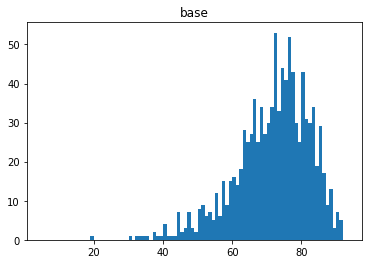

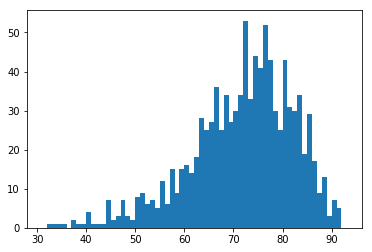

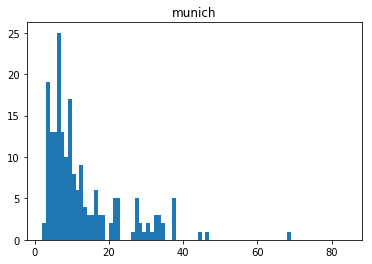

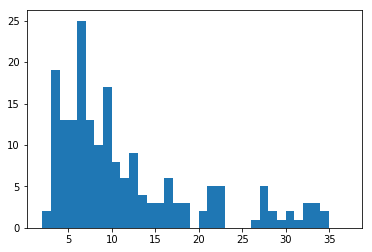

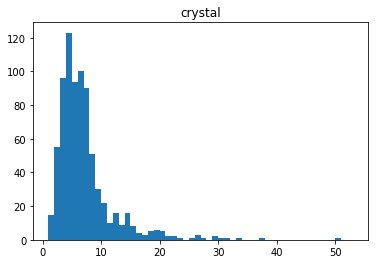

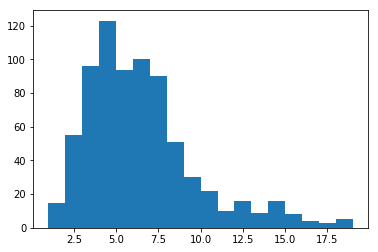

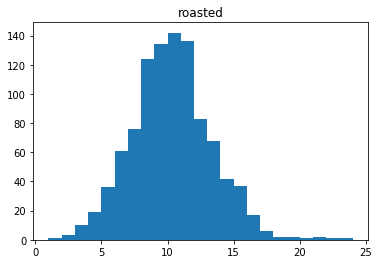

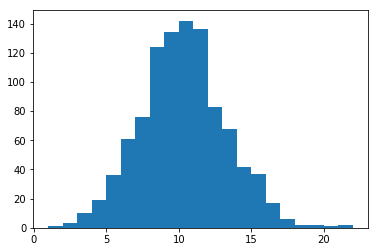

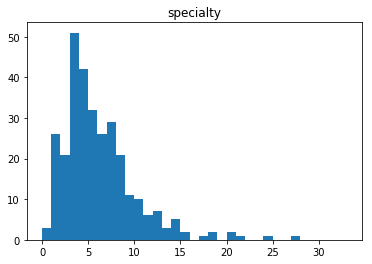

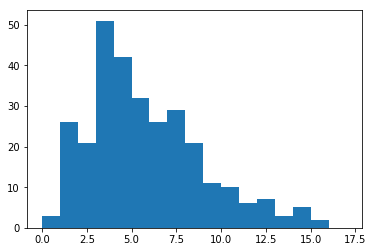

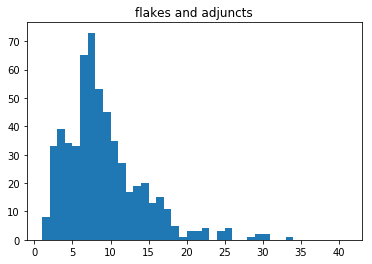

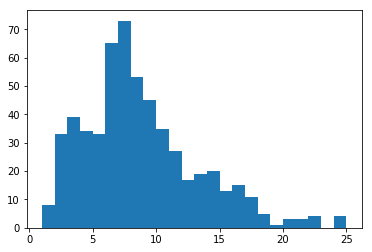

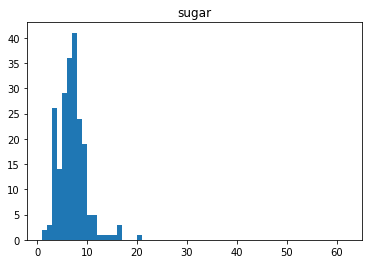

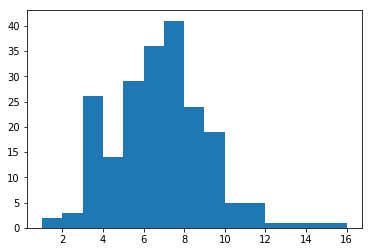

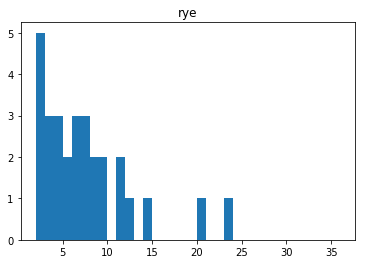

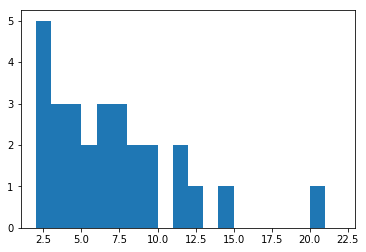

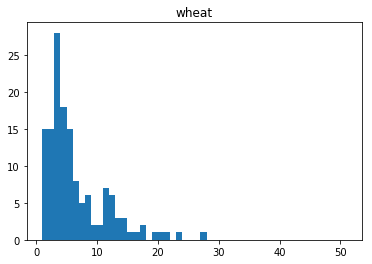

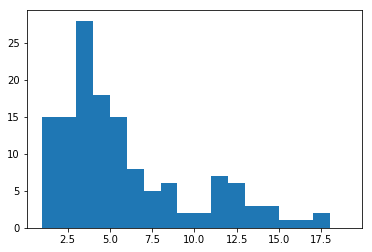

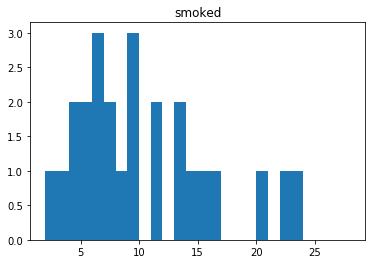

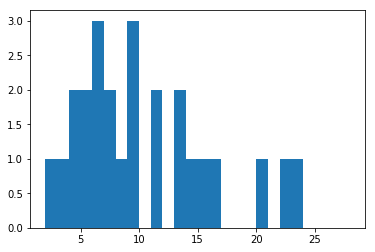

In [135]:
for category, usage in category_usage:
    np_usage = np.array([n for n in usage if n > 0])
    if len(np_usage)/len(usage) < 0.025: 
        print('{} in less than 2.5% of recipes'.format(category))
    else:
        new_usage = reject_outliers(np_usage)
        plt.title(category)
        plt.hist(np_usage, bins=range(int(round(min(np_usage))), int(round(max(np_usage)))))
        plt.show()
        plt.hist(new_usage, bins=range(int(round(min(new_usage))), int(round(max(new_usage)))))
        plt.show()